In [206]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
import os
from surprise.model_selection import train_test_split
from surprise import accuracy
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise.model_selection import RandomizedSearchCV
from surprise.model_selection import GridSearchCV


## Matrix factorization using surprise library

In [196]:
file_path = os.path.expanduser("../output/score_matrix_nomix.csv")

In [197]:
reader = Reader(sep=",", skip_lines=1)
data = Dataset.load_from_file(file_path, reader)

### Simple test with train/test split, no hyperparams tuning

In [199]:
trainset, testset = train_test_split(data, test_size=0.3)

In [200]:
algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

In [201]:
accuracy.rmse(predictions)

RMSE: 0.2126


0.21263818811117371

### Testing possible predictions with full dataset

In [202]:
train = data.build_full_trainset()

In [203]:
algo.fit(train)

In [148]:
X = np.zeros((3179, 494))
for d in tqdm(range(0, 3179)):
    for n in range(0, 494):
        X[d,n] = algo.predict(str(d),str(n))[3]

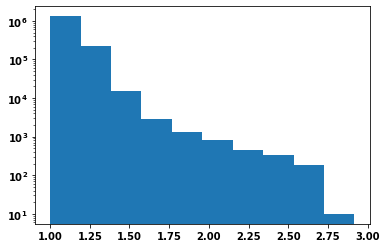

In [158]:
plt.hist(X.flatten())
plt.yscale("log")

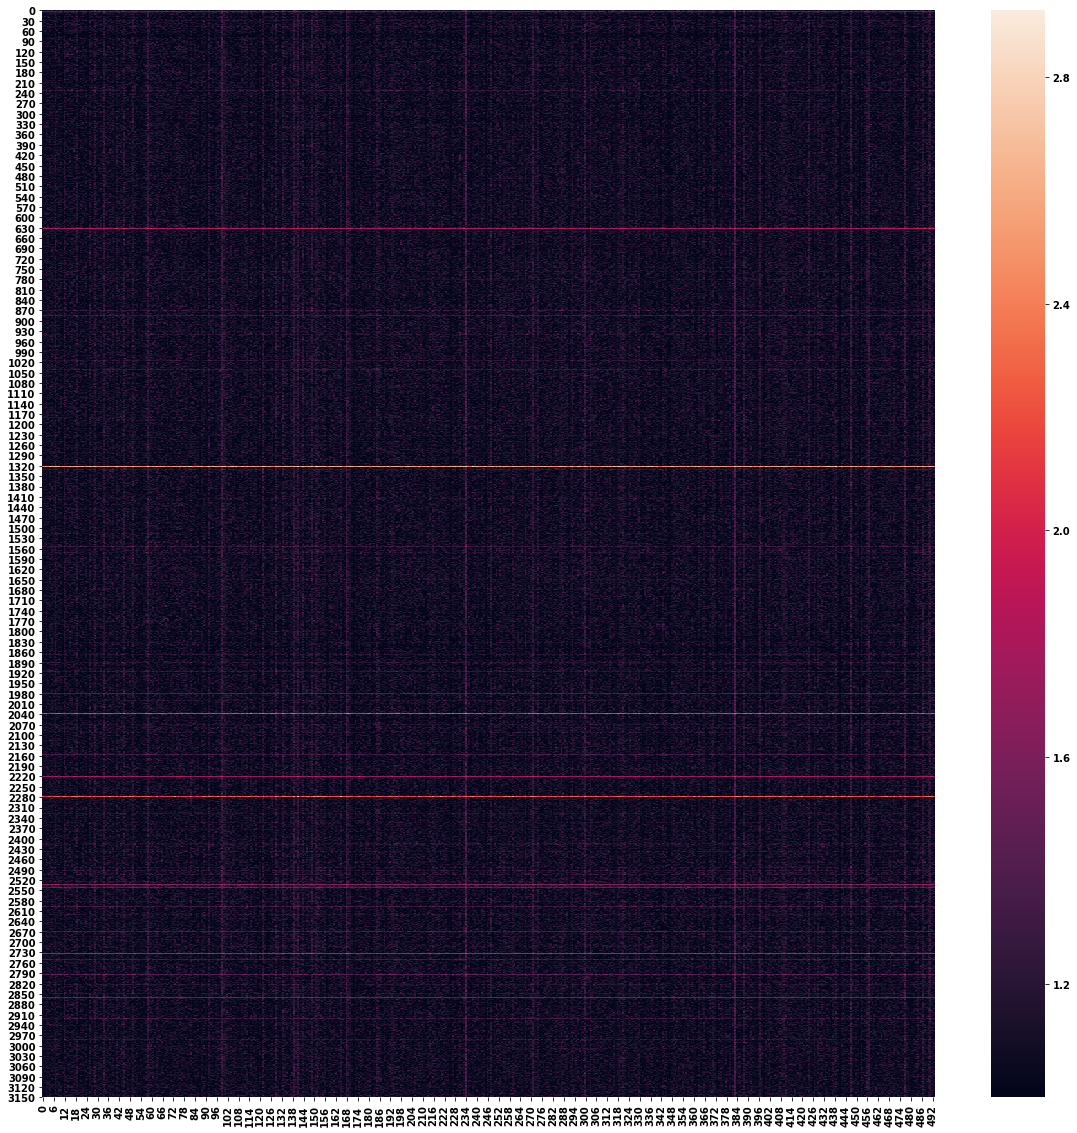

In [163]:
plt.figure(figsize=(20, 20))
sns.heatmap(X)

### Implementing CV to choose params

In [177]:
param_grid = {'lr_all': np.logspace(-4, 0, 20),
              'reg_all': np.logspace(-4, 0, 20),
              'n_factors': range(1, 1001)}

gs = RandomizedSearchCV(SVD, param_grid, n_iter = 500, measures=['rmse'], cv=5, n_jobs = -2, joblib_verbose=2)
gs.fit(data)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-2)]: Done 351 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-2)]: Done 634 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-2)]: Done 999 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-2)]: Done 1444 tasks      | elapsed: 20.6min
[Parallel(n_jobs=-2)]: Done 1971 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-2)]: Done 2500 out of 2500 | elapsed: 34.6min finished


In [178]:
print(gs.best_score)
print(gs.best_params)

{'rmse': 0.17176220014123145}
{'rmse': {'lr_all': 0.14384498882876628, 'reg_all': 0.03359818286283781, 'n_factors': 479}}


In [180]:
param_grid = {'lr_all': np.logspace(-1, 0, 20),
              'reg_all': np.logspace(-2, 0, 20),
              'n_factors': range(400, 501)}

gs = RandomizedSearchCV(SVD, param_grid, n_iter = 100, measures=['rmse'], cv=5, n_jobs = -2, joblib_verbose=2)
gs.fit(data)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-2)]: Done 148 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-2)]: Done 351 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-2)]: Done 500 out of 500 | elapsed:  5.8min finished


In [181]:
print(gs.best_score)
print(gs.best_params)

{'rmse': 0.17367612380485925}
{'rmse': {'lr_all': 0.16237767391887217, 'reg_all': 0.026366508987303583, 'n_factors': 425}}


Good enough params. Fitting the model:

In [186]:
s = SVD(n_factors=479, lr_all = 0.16237767391887217, reg_all = 0.026366508987303583)
s.fit(train)

In [193]:
for d in tqdm(range(0, 3179)):
    for n in range(0, 494):
        X[d,n] = s.predict(str(d),str(n))[3]

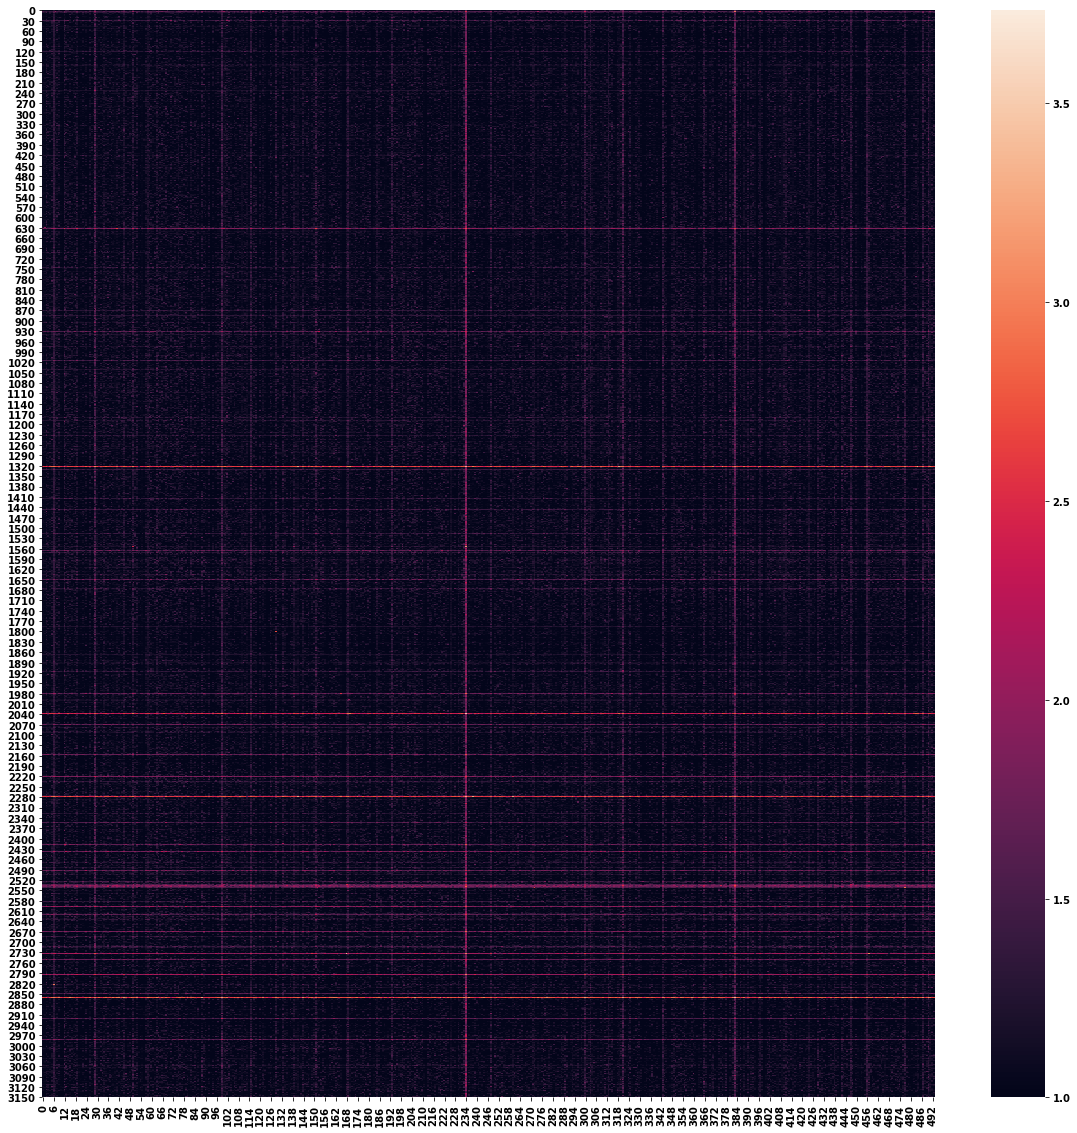

In [194]:
import seaborn as sns
plt.figure(figsize=(20, 20))
sns.heatmap(X)

## Another test using different scoring method

In [212]:
file_path = os.path.expanduser("../output/score_matrix_cat.csv")
reader = Reader(sep=",", skip_lines=1)
data = Dataset.load_from_file(file_path, reader)

In [213]:
trainset, testset = train_test_split(data, test_size=0.3)
fact2 = SVD()
fact2.fit(trainset)
predictions = fact2.test(testset)
accuracy.rmse(predictions)

RMSE: 0.6419


0.6418798938842083

In [214]:
train = data.build_full_trainset()
fact2.fit(train)

In [219]:
X2 = np.zeros((3179, 494))
for d in tqdm(range(0, 3179)):
    for n in range(0, 494):
        X2[d,n] = fact2.predict(str(d),str(n))[3]

In [221]:
X2 = np.rint(X2)

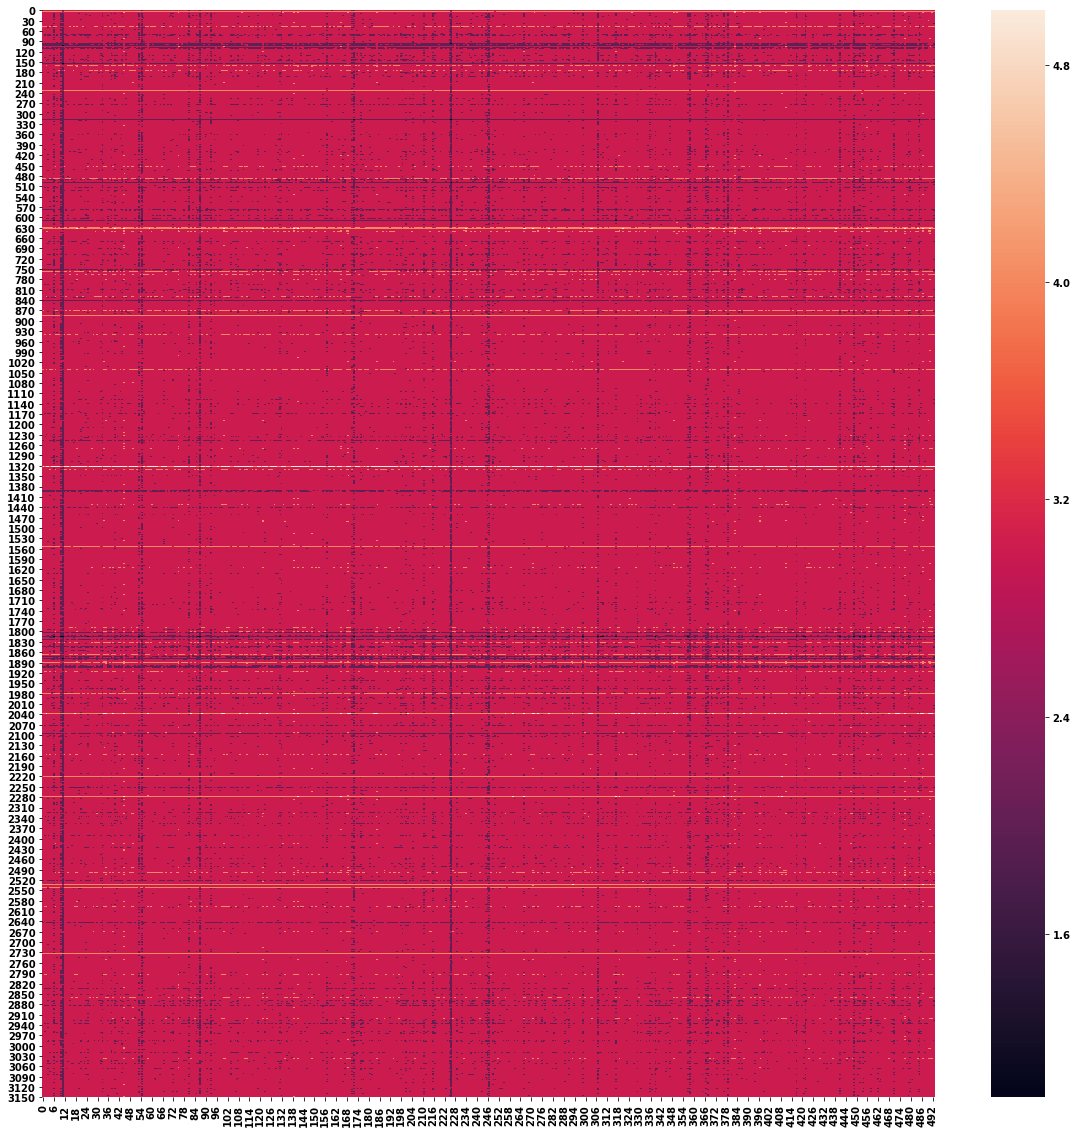

In [225]:
plt.figure(figsize=(20, 20))
sns.heatmap(X2)